## Importing Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet101, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import os
import random
import shutil


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Data Preprocessing and Sampling

In [4]:
# Define paths to the original data directories
train_data_true = "/content/drive/MyDrive/Transfer_Learning/train/train/true"
test_data_true = "/content/drive/MyDrive/Transfer_Learning/test/test/true"

train_data_false = "/content/drive/MyDrive/Transfer_Learning/train/train/false"
test_data_false = "/content/drive/MyDrive/Transfer_Learning/test/test/false"

# Define paths to the new subset data directories
subset_train_data_false = "/content/drive/MyDrive/Transfer_Learning/subset_dir/subset_train/false"
subset_test_data_false = "/content/drive/MyDrive/Transfer_Learning/subset_dir/subset_test/false"

subset_train_data_true = "/content/drive/MyDrive/Transfer_Learning/subset_dir/subset_train/true"
subset_test_data_true = "/content/drive/MyDrive/Transfer_Learning/subset_dir/subset_test/true"

In [ ]:
# def create_subset_with_subdirs(original_dir_true, original_dir_false, subset_dir_true, subset_dir_false, num_samples):
    # Ensure the subset directories exist
    #if not os.path.exists(subset_dir_true):
        os.makedirs(subset_dir_true)
    #if not os.path.exists(subset_dir_false):
        os.makedirs(subset_dir_false)

    # Collect all image paths from both true and false directories
    #all_images_true = [os.path.join(original_dir_true, img) for img in os.listdir(original_dir_true) if img.endswith(('jpg', 'jpeg', 'png'))]
    #all_images_false = [os.path.join(original_dir_false, img) for img in os.listdir(original_dir_false) if img.endswith(('jpg', 'jpeg', 'png'))]

    # Debugging: Print the number of images found and the first few image paths for both classes
    # print(f"Found {len(all_images_true)} images in {original_dir_true}")
    # print(f"First 5 true images: {all_images_true[:5]}")
    # print(f"Found {len(all_images_false)} images in {original_dir_false}")
    # print(f"First 5 false images: {all_images_false[:5]}")

    # Check if there are enough images
    # if len(all_images_true) < num_samples or len(all_images_false) < num_samples:
        #raise ValueError(f"Not enough images in the dataset. Found {len(all_images_true)} true images and {len(all_images_false)} false images, needed {num_samples} each.")

    # Randomly select images
    # selected_images_true = random.sample(all_images_true, num_samples)
    # selected_images_false = random.sample(all_images_false, num_samples)

    # Copy selected images to subset directories
    # for img in selected_images_true:
        #img_name = os.path.basename(img)
        #dst = os.path.join(subset_dir_true, img_name)
        #shutil.copyfile(img, dst)

    # for img in selected_images_false:
        #img_name = os.path.basename(img)
        #dst = os.path.join(subset_dir_false, img_name)
        #shutil.copyfile(img, dst)

# Number of samples to use
# num_samples_per_dataset = 250

# Create subsets for training and testing
# create_subset_with_subdirs(train_data_true, train_data_false, subset_train_data_true, subset_train_data_false, num_samples_per_dataset)
# create_subset_with_subdirs(test_data_true, test_data_false, subset_test_data_true, subset_test_data_false, num_samples_per_dataset)


Found 2219 images in /content/drive/MyDrive/Transfer_Learning/train/train/true
First 5 true images: ['/content/drive/MyDrive/Transfer_Learning/train/train/true/1043.png', '/content/drive/MyDrive/Transfer_Learning/train/train/true/1250.png', '/content/drive/MyDrive/Transfer_Learning/train/train/true/1396.png', '/content/drive/MyDrive/Transfer_Learning/train/train/true/1687.png', '/content/drive/MyDrive/Transfer_Learning/train/train/true/1797.png']
Found 2230 images in /content/drive/MyDrive/Transfer_Learning/train/train/false
First 5 false images: ['/content/drive/MyDrive/Transfer_Learning/train/train/false/1786.png', '/content/drive/MyDrive/Transfer_Learning/train/train/false/2134.png', '/content/drive/MyDrive/Transfer_Learning/train/train/false/374.png', '/content/drive/MyDrive/Transfer_Learning/train/train/false/1927.png', '/content/drive/MyDrive/Transfer_Learning/train/train/false/334.png']
Found 557 images in /content/drive/MyDrive/Transfer_Learning/test/test/true
First 5 true imag

In [5]:
# Define paths to the data directories

# Get the project root directory
ROOT_DIR = "/content/drive/MyDrive/Transfer_Learning/"

# Declare data directories
subset_train_data_dir = os.path.join(ROOT_DIR, 'subset_dir/subset_train')
subset_test_data_dir = os.path.join(ROOT_DIR, 'subset_dir/subset_test')

In [6]:
# Image dimensions
img_height, img_width = 224, 224

# Batch size
batch_size = 16

# Data augmentation and preprocessing for train data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Data preprocessing for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate train and test data batches from the subset directories
train_generator = train_datagen.flow_from_directory(
    subset_train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)

test_generator = test_datagen.flow_from_directory(
    subset_test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)


Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


## Model Definitions

In [7]:
# Defining the models
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
resnet_model = ResNet101(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

29084464/29084464 [==============================] - 0s 0us/step


## Fine-tuning pre-selected models

In [12]:
# Freezing convolutional base for all models
for model in [vgg_model, resnet_model, densenet_model]:
    for layer in model.layers:
        layer.trainable = False

# Adding custom top layers for classification
def add_top_layers(base_model):
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Creating fine-tuned models
vgg_finetuned = add_top_layers(vgg_model)
resnet_finetuned = add_top_layers(resnet_model)
densenet_finetuned = add_top_layers(densenet_model)


# Compiling models
for model in [vgg_finetuned, resnet_finetuned, densenet_finetuned]:
    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

## Model Training

In [10]:
# Defining early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the models with early stopping
epochs = 5
for model in [vgg_finetuned, resnet_finetuned, densenet_finetuned]:
    model.fit(
        train_generator,
        steps_per_epoch=train_generator.n // batch_size,
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=test_generator.n // batch_size,
        callbacks=[early_stopping])

Epoch 1/5
31/31 [==============================] - 636s 21s/step - loss: 1.2237 - accuracy: 0.5351 - val_loss: 0.7802 - val_accuracy: 0.5040
Epoch 2/5
31/31 [==============================] - 635s 21s/step - loss: 0.8023 - accuracy: 0.5165 - val_loss: 0.6481 - val_accuracy: 0.6431
Epoch 3/5
31/31 [==============================] - 635s 21s/step - loss: 0.7257 - accuracy: 0.5165 - val_loss: 0.6332 - val_accuracy: 0.6653
Epoch 4/5
31/31 [==============================] - 635s 21s/step - loss: 0.6647 - accuracy: 0.6136 - val_loss: 0.6270 - val_accuracy: 0.6512
Epoch 5/5
31/31 [==============================] - 625s 20s/step - loss: 0.6338 - accuracy: 0.6343 - val_loss: 0.6165 - val_accuracy: 0.6552
Epoch 1/5
31/31 [==============================] - 371s 12s/step - loss: 2.6036 - accuracy: 0.4711 - val_loss: 0.7102 - val_accuracy: 0.4819
Epoch 2/5
31/31 [==============================] - 358s 12s/step - loss: 0.8004 - accuracy: 0.4938 - val_loss: 0.7081 - val_accuracy: 0.5363
Epoch 3/5
31/

## Evaluation and Performance Metrics

In [11]:
# Initialize lists to store metrics
model_names = ['VGG16', 'ResNet101', 'DenseNet121']
accuracies = []
losses = []
precisions = []
recalls = []
f1_scores = []

# Store predictions and true labels
preds = []
true_labels = []

# Evaluate and print metrics for each model
for model, name in zip([vgg_finetuned, resnet_finetuned, densenet_finetuned], model_names):
    print(f"Evaluating {name}...")
    test_loss, test_accuracy = model.evaluate(test_generator)

    # Predictions
    y_pred = model.predict(test_generator)
    y_pred_classes = np.round(y_pred).astype(int).flatten()
    preds.append(y_pred_classes)

    # True labels
    y_true = test_generator.classes
    true_labels = y_true  # assuming true labels are the same for all models

    # Calculate metrics
    precision = precision_score(y_true, y_pred_classes, average='binary')
    recall = recall_score(y_true, y_pred_classes, average='binary')
    f1 = f1_score(y_true, y_pred_classes, average='binary')

    # Append metrics to lists
    accuracies.append(test_accuracy)
    losses.append(test_loss)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Create a DataFrame to display the metrics in a tabular format
metrics_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Loss': losses,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})

# Display the DataFrame
print(metrics_df)

Evaluating VGG16...
32/32 [==============================] - 315s 10s/step
Evaluating ResNet101...
32/32 [==============================] - 177s 5s/step
Evaluating DenseNet121...
32/32 [==============================] - 88s 3s/step
         Model  Accuracy      Loss  Precision  Recall  F1 Score
0        VGG16     0.656  0.616238   0.625806   0.776  0.692857
1    ResNet101     0.554  0.689052   0.532847   0.876  0.662632
2  DenseNet121     0.662  0.779899   0.616046   0.860  0.717863


## Visualizations

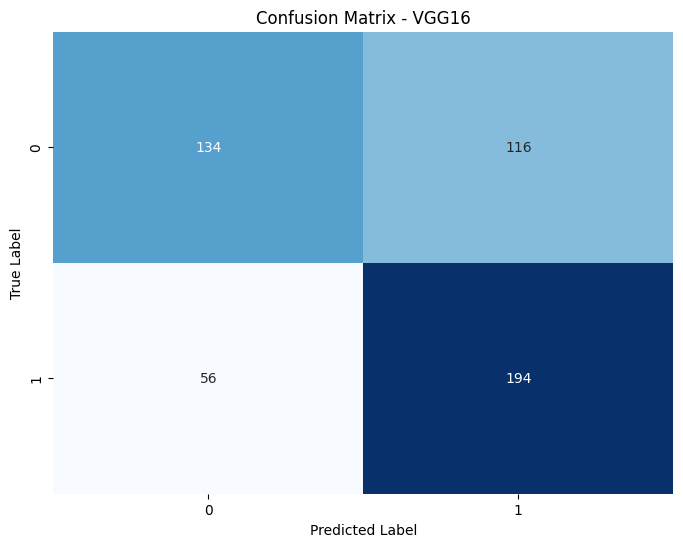

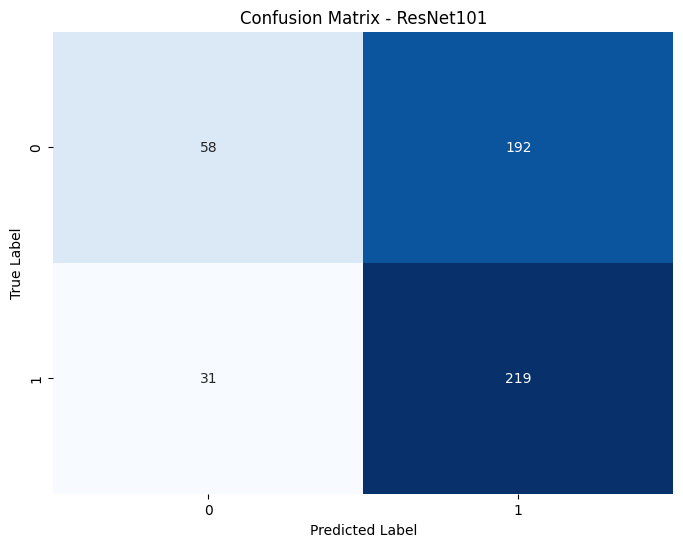

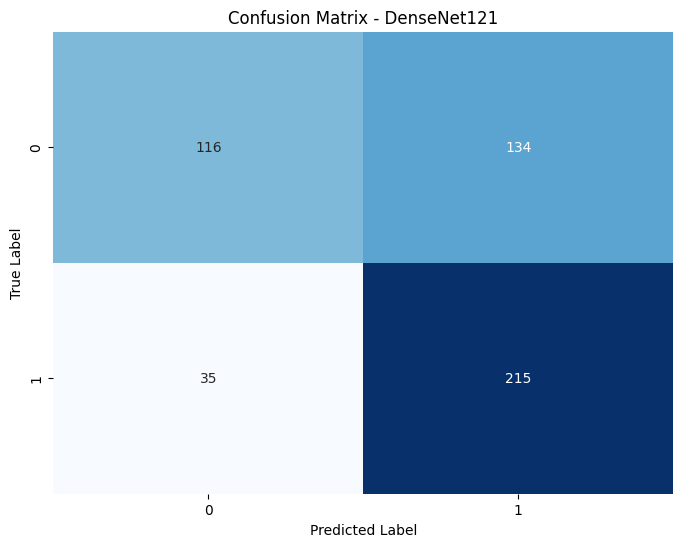

In [14]:
# Plot the confusion matrices
for model_name, predictions in zip(model_names, preds):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()